In [1]:
import torch
from torch import nn


In [2]:
import torch
from torch import nn
from datasets import load_dataset
from PIL import Image
import numpy as np
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Load MNIST dataset
dataset = load_dataset("mnist")


# Print the number of training and test samples
print(f"Number of training samples: {len(dataset['train'])}")
print(f"Number of test samples: {len(dataset['test'])}")


# Calculate mean and std for MNIST
# Convert images to tensors first
mnist_train = dataset["train"].with_transform(lambda examples: {'image': [np.array(img) for img in examples['image']]})
images = np.stack(mnist_train['image'])
images = images.astype(np.float32) / 255.0  # Normalize to [0, 1]
mean = np.mean(images)
std = np.std(images)

image = dataset["train"]["image"][0].convert("RGB") # Convert PIL image to RGB (3 channels)

# Define a transform to preprocess the image for torchvision models
# ResNet models typically expect 224x224 input size, but for MNIST we can resize to 28x28
# and use the calculated normalization
preprocess = transforms.Compose([
    transforms.Resize(28), # Resize the image (MNIST images are 28x28)
    transforms.ToTensor(), # Convert PIL Image to PyTorch Tensor
    transforms.Normalize(mean=[mean]*3, std=[std]*3) # Use calculated MNIST normalization (repeat for 3 channels)
])

# Preprocess the image
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0) # Create a mini-batch as expected by the model

# Load a pre-trained ResNet18 model from torchvision.models
model = models.resnet18(pretrained=True)

# Freeze all layers except the final fully connected layer
for name, param in model.named_parameters():
    if 'fc' not in name:
        param.requires_grad = False
    else:
        param.requires_grad = True # Ensure the final layer is unfrozen

# Since this is a pre-trained ImageNet model, the final layer expects 1000 classes.
# For MNIST (10 classes), we need to modify the final fully connected layer.
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10) # 10 classes for MNIST

# Set the model to evaluation mode (important for inference with frozen layers)
model.eval()

with torch.no_grad():
    logits = model(input_batch) # Pass the processed input batch to the model

# model predicts one of the 10 classes
predicted_label = logits.argmax(-1).item()
print(f"Predicted class index: {predicted_label}")
print(f"Calculated MNIST Mean: {mean:.4f}, Std: {std:.4f}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

mnist/train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

mnist/test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Number of training samples: 60000
Number of test samples: 10000


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 123MB/s]


Predicted class index: 9
Calculated MNIST Mean: 0.1307, Std: 0.3081


Epoch [1/5], Train Loss: 1.2078, Train Acc: 0.5814, Val Loss: 0.9919, Val Acc: 0.6536
Epoch [2/5], Train Loss: 0.9814, Train Acc: 0.6467, Val Loss: 0.9311, Val Acc: 0.6676
Epoch [3/5], Train Loss: 0.9550, Train Acc: 0.6551, Val Loss: 0.9231, Val Acc: 0.6749
Epoch [4/5], Train Loss: 0.9386, Train Acc: 0.6592, Val Loss: 0.9039, Val Acc: 0.6745
Epoch [5/5], Train Loss: 0.9307, Train Acc: 0.6615, Val Loss: 0.9148, Val Acc: 0.6711


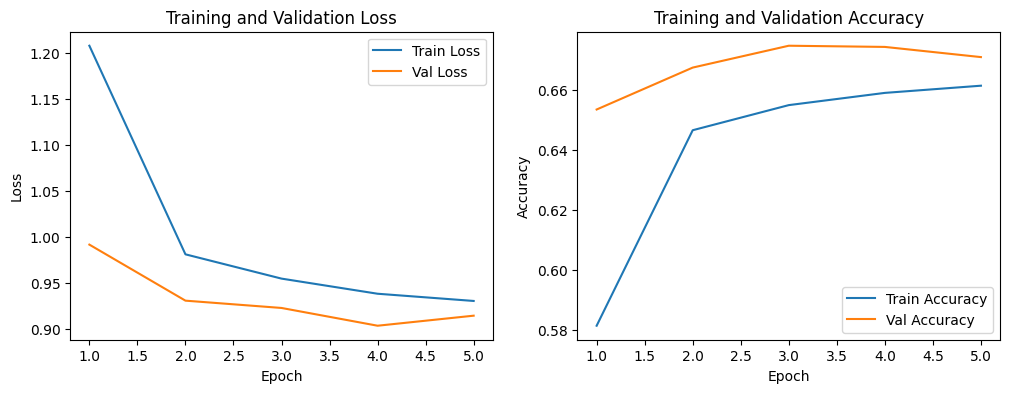

In [7]:
import torch
from torch import nn
import torchvision.models as models
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from datasets import load_dataset # Import load_dataset to get MNIST for mean/std calculation
import numpy as np # Import numpy for mean/std calculation
from torch import optim
import matplotlib.pyplot as plt

# Assuming model is defined and modified for 10 classes in a previous cell

# Calculate mean and std for MNIST (reusing the logic from the previous MNIST cell)
mnist_dataset = load_dataset("mnist")
mnist_train_images = np.stack([np.array(img) for img in mnist_dataset["train"]["image"]])
mnist_train_images = mnist_train_images.astype(np.float32) / 255.0
mean = np.mean(mnist_train_images)
std = np.std(mnist_train_images)


# Define a transform sequence
preprocess_fashion = transforms.Compose([
    transforms.Resize(28), # Resize the image to 28x28
    transforms.ToTensor(), # Convert PIL Image to PyTorch Tensor
    transforms.Normalize(mean=[mean], std=[std]) # Use calculated MNIST normalization for 1 channel
])

# Load Fashion-MNIST training dataset
fashion_train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=preprocess_fashion)

# Load Fashion-MNIST testing dataset
fashion_test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=preprocess_fashion)

# Create DataLoaders
batch_size = 64
fashion_train_dataloader = DataLoader(fashion_train_dataset, batch_size=batch_size, shuffle=True)
fashion_test_dataloader = DataLoader(fashion_test_dataset, batch_size=batch_size, shuffle=False)

# Define the optimizer
# Assuming model is defined in a previous cell and its final layer is modified for 10 classes
# We need to re-define the optimizer after modifying the model's final layer
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


# Define the loss function
criterion = nn.CrossEntropyLoss()


def train_epoch(model, dataloader, optimizer, criterion):
    model.train() # training mode activated
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for images, labels in dataloader:
        optimizer.zero_grad() #clears the gradients from the prev. step
        outputs = model(images) # foward pass
        loss = criterion(outputs, labels) # calculates the loss
        loss.backward() # computes the gradients of the loss with respect to the model's parameters.
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1) # getting the max value from 10 predictions
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

# Modify the first convolutional layer to accept 1 input channel
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Start the training loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 5 # number of epochs

for epoch in range(num_epochs):
    # Train the model for one epoch
    train_loss, train_acc = train_epoch(model, fashion_train_dataloader, optimizer, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluate the model on the test set
    val_loss, val_acc = evaluate_model(model, fashion_test_dataloader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print the metrics for the current epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Plot the metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [3]:
class ResLayer(nn.Module):
     def __init__(self,ni,no,kernel_size,stride=1):
        super(ResLayer, self).__init__()
        padding = kernel_size - 2
        self.conv = nn.Sequential(
            nn.Conv2d(ni, no, kernel_size, stride,
                      padding=padding),
            nn.ReLU()
        )

        def forward(self, x):
         return self.conv(x) + x

